## Data wrangling2 (part1)

In [163]:
import tqdm.auto
import pandas as pd
import numpy as np
import holidays
import func
import math
import pmdarima as pm
from statsforecast import StatsForecast
from statsforecast.models import AutoARIMA, AutoETS, Naive, SeasonalNaive #Imports the models you will use
from datetime import date
from dateutil.relativedelta import relativedelta
import datetime
from tbats import TBATS
from pmdarima.preprocessing import FourierFeaturizer
from scipy import stats

#INPUT_PATH = "C:/Users/u00378/Desktop/tcc_est_unb"
INPUT_PATH = "C:/Users/Igor/Desktop/TCC"

df = pd.read_pickle(f'{INPUT_PATH}/dados/tcc_data.pkl')


#########################
### Regiões do brasil ###
#########################
#NORTE ok
norte = ['AM', 'RR', 'AP', 'PA', 'TO', 'RO', 'AC']
#NORDESTE ok
nordeste = ['MA', 'PI', 'CE', 'RN', 'PE',\
            'PB', 'SE', 'AL', 'BA']
#CENTRO-OESTE + DF ok
centro_oeste = ['MT', 'MS', 'GO', 'DF']
#SUDESTE ok
sudeste = ['SP', 'RJ', 'ES', 'MG']
#SUL ok
sul = ['PR', 'RS', 'SC']

regioes = {'NORTE':norte, 'NORDESTE':nordeste, 'CENTRO_OESTE':centro_oeste, 'SUDESTE':sudeste, 'SUL':sul}

df['weekday'] = list(map(lambda x: x.weekday(), df['data_inversa']))
df = pd.get_dummies(df, columns=['weekday'], drop_first=True)

isnt_na = lambda x: False if bool(__import__('pandas').isna(x)) else True
filtro1 = np.array(list(map(isnt_na, df['uf'])))
filtro2 = np.array((list(map(isnt_na, df['br']))))

df_tcc = df[(filtro1) & (filtro2)]


def effect_long_holiday(date, uf):
    import holidays
    hholidays = holidays.country_holidays('BR', subdiv=uf) 
    date_after1 = pd.to_datetime(date) + np.timedelta64(1,'D')
    date_after3 = pd.to_datetime(date) + np.timedelta64(3,'D')
    
    if (date_after1.day_name() == 'Friday') and (hholidays.get(date_after1)!= None):
        return 1
    elif (date_after3.day_name() == 'Monday') and (hholidays.get(date_after3)!= None):
        return 1
    
    else:
        return 0
    

def is_long_holiday(date, uf):
    import holidays
    hholidays = holidays.country_holidays('BR', subdiv=uf)
    date = pd.to_datetime(date)
    if (date.day_name() == 'Friday') and (hholidays.get(date)!= None):
        return 1
    else:
        return 0
    

train_regiao_df = pd.DataFrame()
test_regiao_df = pd.DataFrame()
for regiao in regioes:
    train = df_tcc[(df_tcc['uf'].isin(regioes[regiao])) & (df_tcc['data_inversa'] <= '2023-01-31')].groupby('data_inversa')['id'].agg('count').resample('D').sum()
    test = df_tcc[(df_tcc['uf'].isin(regioes[regiao])) & (df_tcc['data_inversa'] >= '2023-02-01')&\
                  (df_tcc['data_inversa'] <= '2023-02-28')].groupby('data_inversa')['id'].agg('count').resample('D').sum()
    
    index_train = pd.date_range(start = '2007-01-01', end = '2023-01-31', freq = 'd')
    train = train.reindex(index=index_train, fill_value=0)

    index_test = pd.date_range(start = '2023-02-01', end = '2023-02-28', freq = 'd')
    test = test.reindex(index=index_test, fill_value=0)

    holidays_train = np.zeros(shape= len(index_train))
    effect_long_holiday_train = np.zeros(shape= len(index_train))
    long_holiday_train = np.zeros(shape= len(index_train))

    holidays_test_test = np.zeros(shape= len(index_test))
    effect_long_holiday_test = np.zeros(shape= len(index_test))
    long_holiday_test = np.zeros(shape= len(index_test))
    for uf in regioes[regiao]:

        holidays_train += np.array(list(map(lambda x: 1 if holidays.country_holidays('BR', subdiv=uf).get(x) != None else 0,index_train)))
        effect_long_holiday_train += np.array(list(map(lambda x: effect_long_holiday(x, uf), index_train)))
        long_holiday_train += np.array(list(map(lambda x: is_long_holiday(x, uf), index_train)))
        

        holidays_test_test += np.array(list(map(lambda x: 1 if holidays.country_holidays('BR', subdiv=uf).get(x) != None else 0, index_test)))
        effect_long_holiday_test += np.array(list(map(lambda x: effect_long_holiday(x, uf), index_test)))
        long_holiday_test += np.array(list(map(lambda x: is_long_holiday(x, uf), index_test)))

    holidays_train = holidays_train/len(regioes[regiao])
    effect_long_holiday_train = effect_long_holiday_train/len(regioes[regiao])
    long_holiday_train = long_holiday_train/len(regioes[regiao])

    holidays_test_test = holidays_test_test/len(regioes[regiao])
    effect_long_holiday_test = effect_long_holiday_test/len(regioes[regiao])
    long_holiday_test = long_holiday_test/len(regioes[regiao])

    train_regiao_df = pd.concat([train_regiao_df, pd.DataFrame({'unique_id': [regiao]*len(index_train), 'ds':index_train, 'y':train, 'is_holiday':holidays_train,\
                                                  'effect_long_holiday':effect_long_holiday_train, 'is_long_holiday':long_holiday_train})], axis = 0)
    
    test_regiao_df = pd.concat([test_regiao_df, pd.DataFrame({'unique_id': [regiao]*len(index_test), 'ds':index_test, 'y':test, 'is_holiday':holidays_test_test,\
                                                  'effect_long_holiday':effect_long_holiday_test, 'is_long_holiday':long_holiday_test})], axis = 0)
    

train_regiao_df.to_excel(f'{INPUT_PATH}/git_repo/results/train_regiao_df.xlsx', index = False)
test_regiao_df.to_excel(f'{INPUT_PATH}/git_repo/results/test_regiao_df.xlsx', index = False)

train_regiao_df.to_excel(f'{INPUT_PATH}/git_repo/scripts/train_regiao_df.xlsx', index = False)
test_regiao_df.to_excel(f'{INPUT_PATH}/git_repo/scripts/test_regiao_df.xlsx', index = False)

## Data wrangling3 (part2)

In [101]:
import tqdm.auto
import pandas as pd
import numpy as np
import holidays
import func
import math
import pmdarima as pm
from statsforecast import StatsForecast
from statsforecast.models import AutoARIMA, AutoETS, Naive, SeasonalNaive #Imports the models you will use
from datetime import date
from dateutil.relativedelta import relativedelta
import datetime
from tbats import TBATS
from pmdarima.preprocessing import FourierFeaturizer
from scipy import stats

#INPUT_PATH = "C:/Users/u00378/Desktop/tcc_est_unb"
INPUT_PATH = "C:/Users/Igor/Desktop/TCC"

df = pd.read_pickle(f'{INPUT_PATH}/dados/tcc_data.pkl')


#########################
### Regiões do brasil ###
#########################
#NORTE ok
norte = ['AM', 'RR', 'AP', 'PA', 'TO', 'RO', 'AC']
#NORDESTE ok
nordeste = ['MA', 'PI', 'CE', 'RN', 'PE',\
            'PB', 'SE', 'AL', 'BA']
#CENTRO-OESTE + DF ok
centro_oeste = ['MT', 'MS', 'GO', 'DF']
#SUDESTE ok
sudeste = ['SP', 'RJ', 'ES', 'MG']
#SUL ok
sul = ['PR', 'RS', 'SC']


df['weekday'] = list(map(lambda x: x.weekday(), df['data_inversa']))
df = pd.get_dummies(df, columns=['weekday'], drop_first=True)

isnt_na = lambda x: False if bool(__import__('pandas').isna(x)) else True
filtro1 = np.array(list(map(isnt_na, df['uf'])))
filtro2 = np.array((list(map(isnt_na, df['br']))))

df_tcc = df[(filtro1) & (filtro2)]


def effect_long_holiday(date, uf):
    import holidays
    hholidays = holidays.country_holidays('BR', subdiv=uf) 
    date_after1 = pd.to_datetime(date) + np.timedelta64(1,'D')
    date_after3 = pd.to_datetime(date) + np.timedelta64(3,'D')

    if (date_after1.day_name() == 'Friday') and (hholidays.get(date_after1)!= None):
        return 1
    elif (date_after3.day_name() == 'Monday') and (hholidays.get(date_after3)!= None):
        return 1
    
    else:
        return 0
    

def is_long_holiday(date, uf):
    import holidays
    hholidays = holidays.country_holidays('BR', subdiv=uf)
    date = pd.to_datetime(date)
    if (date.day_name() == 'Friday') and (hholidays.get(date)!= None):
        return 1
    else:
        return 0
    

train_uf_df = pd.DataFrame()
test_uf_df = pd.DataFrame()
for uf in np.unique(df_tcc['uf'].dropna()):
    train = df_tcc[(df_tcc['uf'] == uf) & (df_tcc['data_inversa'] <= '2023-01-31')].groupby('data_inversa')['id'].agg('count').resample('D').sum()
    test = df_tcc[(df_tcc['uf'] == uf) & (df_tcc['data_inversa'] >= '2023-02-01')&\
                  (df_tcc['data_inversa'] <= '2023-02-28')].groupby('data_inversa')['id'].agg('count').resample('D').sum()
    
    index_train = pd.date_range(start = '2007-01-01', end = '2023-01-31', freq = 'd')
    train = train.reindex(index=index_train, fill_value=0)

    index_test = pd.date_range(start = '2023-02-01', end = '2023-02-28', freq = 'd')
    test = test.reindex(index=index_test, fill_value=0)

    holidays_train = list(map(lambda x: 1 if holidays.country_holidays('BR', subdiv=uf).get(x) != None else 0,index_train))
    effect_long_holiday_train = list(map(lambda x: effect_long_holiday(x, uf), index_train))
    long_holiday_train = list(map(lambda x: is_long_holiday(x, uf), index_train))
    

    holidays_test_test = list(map(lambda x: 1 if holidays.country_holidays('BR', subdiv=uf).get(x) != None else 0, index_test))
    effect_long_holiday_test = list(map(lambda x: effect_long_holiday(x, uf), index_test))
    long_holiday_test = list(map(lambda x: is_long_holiday(x, uf), index_test))
    

    train_uf_df = pd.concat([train_uf_df, pd.DataFrame({'unique_id': [uf]*len(index_train), 'ds':index_train, 'y':train, 'is_holiday':holidays_train,\
                                                  'effect_long_holiday':effect_long_holiday_train, 'is_long_holiday':long_holiday_train})], axis = 0)
    
    test_uf_df = pd.concat([test_uf_df, pd.DataFrame({'unique_id': [uf]*len(index_test), 'ds':index_test, 'y':test, 'is_holiday':holidays_test_test,\
                                                  'effect_long_holiday':effect_long_holiday_test, 'is_long_holiday':long_holiday_test})], axis = 0)



train_uf_df.to_excel(f'{INPUT_PATH}/git_repo/results/train_uf_df.xlsx', index = False)
test_uf_df.to_excel(f'{INPUT_PATH}/git_repo/results/test_uf_df.xlsx', index = False)

train_uf_df.to_excel(f'{INPUT_PATH}/git_repo/scripts/train_uf_df.xlsx', index = False)
test_uf_df.to_excel(f'{INPUT_PATH}/git_repo/scripts/test_uf_df.xlsx', index = False)

## CV NIVEL FEDERAL

## SOLUÇÃO PARTE1 & Validação cruzada: avaliação por janela deslizante

In [580]:
import tqdm.auto
import pandas as pd
import numpy as np
import holidays
import func
import math
import pmdarima as pm
from statsforecast import StatsForecast
from statsforecast.models import AutoARIMA, AutoETS, Naive, SeasonalNaive #Imports the models you will use
from datetime import date
from dateutil.relativedelta import relativedelta
import datetime
from tbats import TBATS
from pmdarima.preprocessing import FourierFeaturizer
from scipy import stats

#INPUT_PATH = "C:/Users/u00378/Desktop/tcc_est_unb"
INPUT_PATH = "C:/Users/Igor/Desktop/TCC"


# TIME TO RUN 1100m 46.9s

df = pd.read_pickle(f'{INPUT_PATH}/dados/tcc_data.pkl')

#df['weekday'] = list(map(lambda x: x.weekday(), df['data_inversa']))
#df = pd.get_dummies(df, columns=['weekday'], drop_first=True)

isnt_na = lambda x: False if bool(__import__('pandas').isna(x)) else True
filtro1 = np.array(list(map(isnt_na, df['uf'])))
filtro2 = np.array((list(map(isnt_na, df['br']))))

df_tcc = df[(filtro1) & (filtro2)]

#########################
### Regiões do brasil ###
#########################
#NORTE ok
norte = ['AM', 'RR', 'AP', 'PA', 'TO', 'RO', 'AC']
#NORDESTE ok
nordeste = ['MA', 'PI', 'CE', 'RN', 'PE',\
            'PB', 'SE', 'AL', 'BA']
#CENTRO-OESTE + DF ok
centro_oeste = ['MT', 'MS', 'GO', 'DF']
#SUDESTE ok
sudeste = ['SP', 'RJ', 'ES', 'MG']
#SUL ok
sul = ['PR', 'RS', 'SC']

regioes = {'NORTE':norte, 'NORDESTE':nordeste, 'CENTRO_OESTE':centro_oeste, 'SUDESTE':sudeste, 'SUL':sul}


train_regiao_df = pd.read_excel(f'{INPUT_PATH}/git_repo/results/train_regiao_df.xlsx')
test_regiao_df = pd.read_excel(f'{INPUT_PATH}/git_repo/results/test_regiao_df.xlsx')
#train_df = train_df.iloc[:,1:]
#test_df = test_df.iloc[:,1:]

cols = list(map(lambda x: f'F{x}', range(1, 29)))
submission_file = pd.DataFrame(np.zeros(shape= (27,28)), index = np.unique(df_tcc['uf']), columns = cols)
submission_file.index.names = ['uf']

cv_df = pd.DataFrame(np.zeros(shape= (5,5)), index = regioes.keys(), columns = ['TBATS', 'DHR', 'RAE', 'AutoARIMA', 'sNAIVE'])
cv_df.index.names = ['regiao']


cols = list(map(lambda x: f'F{x}', range(1, 29)))
regiao_forecasts = pd.DataFrame(np.zeros(shape= (5,28)), index = regioes.keys(), columns = cols)


cols = list(map(lambda x: f'Test{x}', range(1, 29)))
regiao_true_test = pd.DataFrame(np.zeros(shape= (5,28)), index = regioes.keys(), columns = cols)

for regiao in regioes:
    mae_tbats = []
    mae_dhr = []
    mae_rae = []
    mae_arima = []
    mae_snaive = []
    final_date = pd.to_datetime('2007-01-01')
    for i in range(1, 5):
        train_df_c = train_regiao_df.copy()
        final_date = final_date +  np.timedelta64(4,'Y')

        test_df_c = train_df_c[(train_df_c['unique_id']==regiao) & (train_df_c['ds'] >= str((final_date + np.timedelta64(1,'D')).date()))\
                              & (train_df_c['ds'] <= str((final_date + np.timedelta64(28,'D')).date()))]
        train_df_c = train_df_c[(train_df_c['unique_id']==regiao) & (train_df_c['ds'] <= str(final_date.date()))]

        #lambda_boxcox = stats.boxcox(train_df_c['y'])[1]

        horizon = len(test_df_c) # Predict the lenght of the test df

        sf1 = StatsForecast(models=[AutoARIMA(season_length=7)], freq='D', n_jobs=-1)
        sf1.fit(df=train_df_c[train_df_c['unique_id']==regiao])
        Y_hat_df1 = sf1.predict(h=horizon, X_df=test_df_c[test_df_c['unique_id']==regiao][['unique_id', 'ds', 'is_holiday', 'effect_long_holiday', 'is_long_holiday']])

        sf2 = StatsForecast(models=[SeasonalNaive(season_length=7)], freq='D', n_jobs=-1)
        sf2.fit(df=train_df_c[train_df_c['unique_id']==regiao][['unique_id', 'ds', 'y']])
        Y_hat_df2 = sf2.predict(h=horizon)

        testee = 1000
        for k in range(1,4,1):
            sf3 = StatsForecast(models=[AutoARIMA(season_length=7, seasonal = False)], freq='D', n_jobs=-1)
            trans = FourierFeaturizer(7, k)
            y_prime, x_f = trans.fit_transform(train_df_c[train_df_c['unique_id']==regiao]['y'].values)
            sf3.fit(df=pd.concat([train_df_c[train_df_c['unique_id']==regiao].reset_index(drop=True), x_f], axis = 1))
            Y_hat_df3 = sf3.predict(h=horizon, X_df=pd.concat([test_df_c[test_df_c['unique_id']==regiao].reset_index(drop=True), pd.DataFrame(x_f[-horizon:])\
                                                               .reset_index(drop=True)], axis = 1).drop('y', axis = 1))
            if func.mae(Y_hat_df3['AutoARIMA'].values, test_df_c['y'].values) < testee:
                dhr_preds = Y_hat_df3['AutoARIMA'].values

                testee = func.mae(Y_hat_df3['AutoARIMA'].values, test_df_c['y'].values)

            
            
        #result_auto_arima = pm.auto_arima(train.values, d = 1, start_p=0, start_q=0, max_p=3, max_q=3,\
        #                          seasonal = True, m = 7, D=1, start_P=0, start_Q=0, max_P=1, max_Q=1,\
        #                            information_criterion='aic', error_action='ignore', stepwise=True)

        result_auto_arima = pm.auto_arima(train_df_c['y'], seasonal = True, m = 7, start_p=0, start_q=0, max_p=1, max_q=1,\
                                          start_P=0, start_Q=0, max_P=1, max_Q=1)
        auto_arima_forecast= result_auto_arima.predict(28)

        result_tbats = TBATS(seasonal_periods=[7, 365.25/12, 365.25], n_jobs=1, \
                              use_box_cox= False, use_arma_errors=False)
        
        fitted_tbats = result_tbats.fit(train_df_c['y'])
        tbats_forecast_valid = fitted_tbats.forecast(steps = horizon)
        
        y_true = test_df_c['y'].values
        tbats_preds = tbats_forecast_valid
        #dhr_preds = Y_hat_df3['AutoARIMA'].values
        rae_preds = Y_hat_df1['AutoARIMA'].values
        arima_preds = auto_arima_forecast
        snaive_preds = Y_hat_df2['SeasonalNaive'].values

        mae_tbats.append(func.mae(tbats_preds, y_true))
        mae_dhr.append(func.mae(dhr_preds, y_true))
        mae_rae.append(func.mae(rae_preds, y_true))
        mae_arima.append(func.mae(arima_preds, y_true))
        mae_snaive.append(func.mae(snaive_preds, y_true))

    cv = {'TBATS': np.mean(mae_tbats), 'DHR':np.mean(mae_dhr), 'RAE': np.mean(mae_rae), 'AutoARIMA': np.mean(mae_arima), 'sNAIVE': np.mean(mae_snaive)}
    cv_df.loc[regiao] = list(cv.values())

    best_model = min(cv, key=cv.get)

    train_df_c = train_regiao_df.copy()
    test_df_c = test_regiao_df.copy()

    train_df_c = train_df_c[(train_df_c['unique_id'] == regiao) & (train_df_c['ds'] <= '2023-01-31')]
    test_df_c = test_df_c[(test_df_c['unique_id'] == regiao) & (test_df_c['ds'] >= '2023-02-01')\
                              & (test_df_c['ds'] <= '2023-02-28')]
    

    regiao_true_test.loc[regiao] = test_df_c[test_df_c['unique_id']==regiao]['y'].values


    #lambda_boxcox = stats.boxcox(train_df_c[train_df_c['unique_id']==uf]['y'].values)[1]
    if best_model == 'TBATS':
        result_tbats = TBATS(seasonal_periods=[7, 365.25/12, 365.25], n_jobs=1, \
                              use_box_cox= False, use_arma_errors=False) 
        fitted_tbats = result_tbats.fit(train_df_c[train_df_c['unique_id']==regiao]['y'].values)
        tbats_forecast = fitted_tbats.forecast(steps = 28)

        regiao_forecasts.loc[regiao] = tbats_forecast

        rot = df_tcc[(df_tcc['uf'].isin(regioes[regiao])) & (df_tcc['data_inversa'] >= '2022-01-01')& (df_tcc['data_inversa'] <= '2023-01-31')].groupby(['uf'])['id']\
            .agg(['nunique'])
        rot['proportion'] = (rot['nunique']/396)/(sum(rot['nunique'])/396) #Top-down approaches: Proportions of the historical averages

        for uf in rot.index.values:
            submission_file.loc[uf] = submission_file.loc[uf] +  (tbats_forecast*rot.loc[uf]['proportion'])

    elif best_model == 'DHR':

        testee = 1000
        for k in range(1,4,1):
            sf1 = StatsForecast(models=[AutoARIMA(season_length=7, seasonal = False)], freq='D', n_jobs=-1)
            trans = FourierFeaturizer(7, k)
            y_prime, x_f = trans.fit_transform(train_df_c[train_df_c['unique_id']==regiao]['y'].values)
            sf1.fit(df=pd.concat([train_df_c[train_df_c['unique_id']==regiao].reset_index(drop=True), x_f], axis = 1))
            Y_hat_df1 = sf1.predict(h=28, X_df=pd.concat([test_df_c[test_df_c['unique_id']==regiao].reset_index(drop=True), pd.DataFrame(x_f[-28:])\
                                                          .reset_index(drop=True)], axis = 1).drop('y', axis = 1))
            if func.mae(Y_hat_df3['AutoARIMA'].values, test_df_c['y'].values) < testee:
                dhr_forecast = Y_hat_df1['AutoARIMA'].values

                testee = func.mae(Y_hat_df3['AutoARIMA'].values, test_df_c['y'].values)

        regiao_forecasts.loc[regiao] = dhr_forecast
        
        rot = df_tcc[(df_tcc['uf'].isin(regioes[regiao])) & (df_tcc['data_inversa'] >= '2022-01-01')& (df_tcc['data_inversa'] <= '2023-01-31')].groupby(['uf'])['id']\
            .agg(['nunique'])
        rot['proportion'] = (rot['nunique']/396)/(sum(rot['nunique'])/396) #Top-down approaches: Proportions of the historical averages

        for uf in rot.index.values:
            submission_file.loc[uf] = submission_file.loc[uf] +  (dhr_forecast*rot.loc[uf]['proportion'])


    elif best_model == 'RAE':
        sf1 = StatsForecast(models=[AutoARIMA(season_length=7)], freq='D', n_jobs=-1)
        sf1.fit(df=train_df_c[train_df_c['unique_id']==regiao])
        Y_hat_df1 = sf1.predict(h=28, X_df=test_df_c[test_df_c['unique_id']==regiao][['unique_id', 'ds', 'is_holiday', 'effect_long_holiday', 'is_long_holiday']])
        rae_forecast = Y_hat_df1['AutoARIMA'].values

        regiao_forecasts.loc[regiao] = rae_forecast

        rot = df_tcc[(df_tcc['uf'].isin(regioes[regiao])) & (df_tcc['data_inversa'] >= '2022-01-01')& (df_tcc['data_inversa'] <= '2023-01-31')].groupby(['uf'])['id']\
            .agg(['nunique'])
        rot['proportion'] = (rot['nunique']/396)/(sum(rot['nunique'])/396) #Top-down approaches: Proportions of the historical averages
        for uf in rot.index.values:
            submission_file.loc[uf] = submission_file.loc[uf] +  (rae_forecast*rot.loc[uf]['proportion'])
            
    elif best_model == 'AutoARIMA':
        sf1 = StatsForecast(models=[AutoARIMA(season_length=7)], freq='D', n_jobs=-1)
        sf1.fit(df=train_df_c[train_df_c['unique_id']==regiao][['unique_id', 'ds', 'y']])
        Y_hat_df1 = sf1.predict(h=28)
        autoarima_forecast = Y_hat_df1['AutoARIMA'].values
        regiao_forecasts.loc[regiao] = autoarima_forecast

        rot = df_tcc[(df_tcc['uf'].isin(regioes[regiao])) & (df_tcc['data_inversa'] >= '2022-01-01')& (df_tcc['data_inversa'] <= '2023-01-31')].groupby(['uf'])['id']\
            .agg(['nunique'])
        rot['proportion'] = (rot['nunique']/396)/(sum(rot['nunique'])/396) #Top-down approaches: Proportions of the historical averages
        for uf in rot.index.values:
            submission_file.loc[uf] = submission_file.loc[uf] +  (autoarima_forecast*rot.loc[uf]['proportion'])

    elif best_model == 'sNAIVE':
        sf1 = StatsForecast(models=[SeasonalNaive(season_length=7)], freq='D', n_jobs=-1)
        sf1.fit(df=train_df_c[train_df_c['unique_id']==uf][['unique_id', 'ds', 'y']])
        Y_hat_df1 = sf1.predict(h=28)
        snaive_forecast = Y_hat_df1['SeasonalNaive'].values

        regiao_forecasts.loc[regiao] = snaive_forecast

        rot = df_tcc[(df_tcc['uf'].isin(regioes[regiao])) & (df_tcc['data_inversa'] >= '2022-01-01')& (df_tcc['data_inversa'] <= '2023-01-31')].groupby(['uf'])['id']\
            .agg(['nunique'])
        rot['proportion'] = (rot['nunique']/396)/(sum(rot['nunique'])/396) #Top-down approaches: Proportions of the historical averages
        for uf in rot.index.values:
            submission_file.loc[uf] = submission_file.loc[uf] +  (snaive_forecast*rot.loc[uf]['proportion'])

submission_file.to_excel(f'{INPUT_PATH}/git_repo/results/submission_file_uf.xlsx')
cv_df.to_excel(f'{INPUT_PATH}/git_repo/results/cv1_summary.xlsx')
regiao_forecasts.to_excel(f'{INPUT_PATH}/git_repo/results/regiao_forecasts.xlsx')
regiao_true_test.to_excel(f'{INPUT_PATH}/git_repo/results/regiao_true_test.xlsx')

C:\Users\Igor\AppData\Roaming\Python\Python310\site-packages\statsforecast\arima.py:680: RuntimeWarning: overflow encountered in subtract
  x -= np.dot(xreg, par[narma + np.arange(ncxreg)])
C:\Users\Igor\AppData\Roaming\Python\Python310\site-packages\statsforecast\arima.py:680: RuntimeWarning: overflow encountered in subtract
  x -= np.dot(xreg, par[narma + np.arange(ncxreg)])


In [643]:
test_series = pd.DataFrame(np.matrix(pd.read_excel('uf_true_test.xlsx').set_index('Unnamed: 0', drop = True)),\
                     index = submission_file.index, columns=submission_file.columns).sum()

forecast_series = forecast_series.sum().values

train_series = pd.read_excel('uf_true_train.xlsx')


func.calculate_MASE(train_series.set_index('Unnamed: 0', drop = True).sum().values, forecast_series.sum().values)

In [659]:
func.calculate_MASE(train_series.set_index('Unnamed: 0', drop = True).sum().values, test_series.values, forecast_series.sum().values) # MASE parte 1 MELHOR!

Needs to be tested.


0.39398801479322215

In [662]:
func.calculate_MASE(train_series.set_index('Unnamed: 0', drop = True).sum().values, test_series.values,\
                    pd.read_excel('uf_forecasts2.xlsx').set_index('Unnamed: 0', drop = True).sum().values) # MASE parte 2

Needs to be tested.


0.4265979267587826

In [663]:
func.calculate_smape(test_series.values, forecast_series.sum().values) # part 1 MELHOR!

10.24

In [664]:
func.calculate_smape(test_series.values, pd.read_excel('uf_forecasts2.xlsx').set_index('Unnamed: 0', drop = True).sum().values) # part 2

11.11

## SOLUÇÃO PARTE 2 & Validação cruzada: avaliação por janela deslizante


CV data: 2007-01-01 to 2023-01-28

train data: 2007-01-01 to 2023-01-31

test data: 2023-02-01 to 2023-02-28

In [116]:
import tqdm.auto
import pandas as pd
import numpy as np
import holidays
import func
import math
import pmdarima as pm
from statsforecast import StatsForecast
from statsforecast.models import AutoARIMA, AutoETS, Naive, SeasonalNaive #Imports the models you will use
from datetime import date
from dateutil.relativedelta import relativedelta
import datetime
from tbats import TBATS
from pmdarima.preprocessing import FourierFeaturizer
from scipy import stats

#INPUT_PATH = "C:/Users/u00378/Desktop/tcc_est_unb"
INPUT_PATH = "C:/Users/Igor/Desktop/TCC"


# TIME TO RUN 1100m 46.9s

df = pd.read_pickle(f'{INPUT_PATH}/dados/tcc_data.pkl')

df['weekday'] = list(map(lambda x: x.weekday(), df['data_inversa']))
df = pd.get_dummies(df, columns=['weekday'], drop_first=True)

isnt_na = lambda x: False if bool(__import__('pandas').isna(x)) else True
filtro1 = np.array(list(map(isnt_na, df['uf'])))
filtro2 = np.array((list(map(isnt_na, df['br']))))

df_tcc = df[(filtro1) & (filtro2)]


train_uf_df = pd.read_excel(f'{INPUT_PATH}/git_repo/results/train_uf_df.xlsx')
test_uf_df = pd.read_excel(f'{INPUT_PATH}/git_repo/results/test_uf_df.xlsx')
#train_df = train_df.iloc[:,1:]
#test_df = test_df.iloc[:,1:]

cols = list(map(lambda x: f'F{x}', range(1, 29)))
submission_file = pd.DataFrame(np.zeros(shape= (208,28)), index = np.unique(df_tcc['br']), columns = cols)
submission_file.index.names = ['br']

cv_df = pd.DataFrame(np.zeros(shape= (27,5)), index = np.unique(df_tcc['uf']), columns = ['TBATS', 'DHR', 'RAE', 'AutoARIMA', 'sNAIVE'])
cv_df.index.names = ['uf']


cols = list(map(lambda x: f'F{x}', range(1, 29)))
uf_forecasts = pd.DataFrame(np.zeros(shape= (27,28)), index = np.unique(df_tcc['uf']), columns = cols)

cols = list(map(lambda x: f'Train{x}', range(1, 5876)))
uf_true_train = pd.DataFrame(np.zeros(shape= (27,5875)), index = np.unique(df_tcc['uf']), columns = cols)

cols = list(map(lambda x: f'Test{x}', range(1, 29)))
uf_true_test = pd.DataFrame(np.zeros(shape= (27,28)), index = np.unique(df_tcc['uf']), columns = cols)

for uf in np.unique(df_tcc['uf'].dropna()):
    mae_tbats = []
    mae_dhr = []
    mae_rae = []
    mae_arima = []
    mae_snaive = []
    final_date = pd.to_datetime('2007-01-01')
    for i in range(1, 5):
        train_df_c = train_uf_df.copy()
        final_date = final_date +  np.timedelta64(4,'Y')

        test_df_c = train_df_c[(train_df_c['unique_id'] == uf) & (train_df_c['ds'] >= str((final_date + np.timedelta64(1,'D')).date()))\
                              & (train_df_c['ds'] <= str((final_date + np.timedelta64(28,'D')).date()))]
        train_df_c = train_df_c[(train_df_c['unique_id'] == uf) & (train_df_c['ds'] <= str(final_date.date()))]

        #lambda_boxcox = stats.boxcox(train_df_c['y'])[1]

        horizon = len(test_df_c) # Predict the lenght of the test df

        sf1 = StatsForecast(models=[AutoARIMA(season_length=7)], freq='D', n_jobs=-1)
        sf1.fit(df=train_df_c[train_df_c['unique_id']==uf])
        Y_hat_df1 = sf1.predict(h=horizon, X_df=test_df_c[test_df_c['unique_id']==uf][['unique_id', 'ds', 'is_holiday', 'effect_long_holiday', 'is_long_holiday']])

        sf2 = StatsForecast(models=[SeasonalNaive(season_length=7)], freq='D', n_jobs=-1)
        sf2.fit(df=train_df_c[train_df_c['unique_id']==uf][['unique_id', 'ds', 'y']])
        Y_hat_df2 = sf2.predict(h=horizon)

        testee = 1000
        for k in range(1,4,1):
            sf3 = StatsForecast(models=[AutoARIMA(season_length=7, seasonal = False)], freq='D', n_jobs=-1)
            trans = FourierFeaturizer(7, k)
            y_prime, x_f = trans.fit_transform(train_df_c[train_df_c['unique_id']==uf]['y'].values)
            sf3.fit(df=pd.concat([train_df_c[train_df_c['unique_id']==uf].reset_index(drop=True), x_f], axis = 1))
            Y_hat_df3 = sf3.predict(h=horizon, X_df=pd.concat([test_df_c[test_df_c['unique_id']==uf].reset_index(drop=True), pd.DataFrame(x_f[-horizon:])\
                                                               .reset_index(drop=True)], axis = 1).drop('y', axis = 1))
            if func.mae(Y_hat_df3['AutoARIMA'].values, test_df_c['y'].values) < testee:
                dhr_preds = Y_hat_df3['AutoARIMA'].values

                testee = func.mae(Y_hat_df3['AutoARIMA'].values, test_df_c['y'].values)

            
            
        #result_auto_arima = pm.auto_arima(train.values, d = 1, start_p=0, start_q=0, max_p=3, max_q=3,\
        #                          seasonal = True, m = 7, D=1, start_P=0, start_Q=0, max_P=1, max_Q=1,\
        #                            information_criterion='aic', error_action='ignore', stepwise=True)

        result_auto_arima = pm.auto_arima(train_df_c['y'], seasonal = True, m = 7, start_p=0, start_q=0, max_p=1, max_q=1,\
                                          start_P=0, start_Q=0, max_P=1, max_Q=1)
        auto_arima_forecast= result_auto_arima.predict(28)

        result_tbats = TBATS(seasonal_periods=[7, 365.25/12, 365.25], n_jobs=1, \
                              use_box_cox= False, use_arma_errors=False)
        
        fitted_tbats = result_tbats.fit(train_df_c['y'])
        tbats_forecast_valid = fitted_tbats.forecast(steps = horizon)
        
        y_true = test_df_c['y'].values
        tbats_preds = tbats_forecast_valid
        #dhr_preds = Y_hat_df3['AutoARIMA'].values
        rae_preds = Y_hat_df1['AutoARIMA'].values
        arima_preds = auto_arima_forecast
        snaive_preds = Y_hat_df2['SeasonalNaive'].values

        mae_tbats.append(func.mae(tbats_preds, y_true))
        mae_dhr.append(func.mae(dhr_preds, y_true))
        mae_rae.append(func.mae(rae_preds, y_true))
        mae_arima.append(func.mae(arima_preds, y_true))
        mae_snaive.append(func.mae(snaive_preds, y_true))

    cv = {'TBATS': np.mean(mae_tbats), 'DHR':np.mean(mae_dhr), 'RAE': np.mean(mae_rae), 'AutoARIMA': np.mean(mae_arima), 'sNAIVE': np.mean(mae_snaive)}
    cv_df.loc[uf] = list(cv.values())

    best_model = min(cv, key=cv.get)

    train_df_c = train_uf_df.copy()
    test_df_c = test_uf_df.copy()

    train_df_c = train_df_c[(train_df_c['unique_id'] == uf) & (train_df_c['ds'] <= '2023-01-31')]
    test_df_c = test_df_c[(test_df_c['unique_id'] == uf) & (test_df_c['ds'] >= '2023-02-01')\
                              & (test_df_c['ds'] <= '2023-02-28')]
    

    uf_true_train.loc[uf] = train_df_c[train_df_c['unique_id']==uf]['y'].values
    uf_true_test.loc[uf] = test_df_c[test_df_c['unique_id']==uf]['y'].values

    #lambda_boxcox = stats.boxcox(train_df_c[train_df_c['unique_id']==uf]['y'].values)[1]
    if best_model == 'TBATS':
        result_tbats = TBATS(seasonal_periods=[7, 365.25/12, 365.25], n_jobs=1, \
                              use_box_cox= False, use_arma_errors=False) 
        fitted_tbats = result_tbats.fit(train_df_c[train_df_c['unique_id']==uf]['y'].values)
        tbats_forecast = fitted_tbats.forecast(steps = 28)

        uf_forecasts.loc[uf] = tbats_forecast

        rot = df_tcc[(df_tcc['uf'] == uf) & (df_tcc['data_inversa'] >= '2022-01-01')& (df_tcc['data_inversa'] <= '2023-01-31')].groupby(['br'])['id']\
            .agg(['nunique'])
        rot['proportion'] = (rot['nunique']/396)/(sum(rot['nunique'])/396) #Top-down approaches: Proportions of the historical averages

        for br in rot.index.values:
            submission_file.loc[br] = submission_file.loc[br] +  (tbats_forecast*rot.loc[br]['proportion'])

    elif best_model == 'DHR':

        testee = 1000
        for k in range(1,4,1):
            sf1 = StatsForecast(models=[AutoARIMA(season_length=7, seasonal = False)], freq='D', n_jobs=-1)
            trans = FourierFeaturizer(7, k)
            y_prime, x_f = trans.fit_transform(train_df_c[train_df_c['unique_id']==uf]['y'].values)
            sf1.fit(df=pd.concat([train_df_c[train_df_c['unique_id']==uf].reset_index(drop=True), x_f], axis = 1))
            Y_hat_df1 = sf1.predict(h=28, X_df=pd.concat([test_df_c[test_df_c['unique_id']==uf].reset_index(drop=True), pd.DataFrame(x_f[-28:])\
                                                          .reset_index(drop=True)], axis = 1).drop('y', axis = 1))
            if func.mae(Y_hat_df3['AutoARIMA'].values, test_df_c['y'].values) < testee:
                dhr_forecast = Y_hat_df1['AutoARIMA'].values

                testee = func.mae(Y_hat_df3['AutoARIMA'].values, test_df_c['y'].values)

        uf_forecasts.loc[uf] = dhr_forecast
        
        rot = df_tcc[(df_tcc['uf'] == uf) & (df_tcc['data_inversa'] >= '2022-01-01')& (df_tcc['data_inversa'] <= '2023-01-31')].groupby(['br'])['id']\
            .agg(['nunique'])
        rot['proportion'] = (rot['nunique']/396)/(sum(rot['nunique'])/396) #Top-down approaches: Proportions of the historical averages

        for br in rot.index.values:
            submission_file.loc[br] = submission_file.loc[br] +  (dhr_forecast*rot.loc[br]['proportion'])


    elif best_model == 'RAE':
        sf1 = StatsForecast(models=[AutoARIMA(season_length=7)], freq='D', n_jobs=-1)
        sf1.fit(df=train_df_c[train_df_c['unique_id']==uf])
        Y_hat_df1 = sf1.predict(h=28, X_df=test_df_c[test_df_c['unique_id']==uf][['unique_id', 'ds', 'is_holiday', 'effect_long_holiday', 'is_long_holiday']])
        rae_forecast = Y_hat_df1['AutoARIMA'].values

        uf_forecasts.loc[uf] = rae_forecast

        rot = df_tcc[(df_tcc['uf'] == uf) & (df_tcc['data_inversa'] >= '2022-01-01')& (df_tcc['data_inversa'] <= '2023-01-31')].groupby(['br'])['id']\
            .agg(['nunique'])
        rot['proportion'] = (rot['nunique']/396)/(sum(rot['nunique'])/396) #Top-down approaches: Proportions of the historical averages
        for br in rot.index.values:
            submission_file.loc[br] = submission_file.loc[br] +  (rae_forecast*rot.loc[br]['proportion'])
            
    elif best_model == 'AutoARIMA':
        sf1 = StatsForecast(models=[AutoARIMA(season_length=7)], freq='D', n_jobs=-1)
        sf1.fit(df=train_df_c[train_df_c['unique_id']==uf][['unique_id', 'ds', 'y']])
        Y_hat_df1 = sf1.predict(h=28)
        autoarima_forecast = Y_hat_df1['AutoARIMA'].values
        uf_forecasts.loc[uf] = autoarima_forecast

        rot = df_tcc[(df_tcc['uf'] == uf) & (df_tcc['data_inversa'] >= '2022-01-01')& (df_tcc['data_inversa'] <= '2023-01-31')].groupby(['br'])['id']\
            .agg(['nunique'])
        rot['proportion'] = (rot['nunique']/396)/(sum(rot['nunique'])/396) #Top-down approaches: Proportions of the historical averages
        for br in rot.index.values:
            submission_file.loc[br] = submission_file.loc[br] +  (autoarima_forecast*rot.loc[br]['proportion'])

    elif best_model == 'sNAIVE':
        sf1 = StatsForecast(models=[SeasonalNaive(season_length=7)], freq='D', n_jobs=-1)
        sf1.fit(df=train_df_c[train_df_c['unique_id']==uf][['unique_id', 'ds', 'y']])
        Y_hat_df1 = sf1.predict(h=28)
        snaive_forecast = Y_hat_df1['SeasonalNaive'].values

        uf_forecasts.loc[uf] = snaive_forecast

        rot = df_tcc[(df_tcc['uf'] == uf) & (df_tcc['data_inversa'] >= '2022-01-01')& (df_tcc['data_inversa'] <= '2023-01-31')].groupby(['br'])['id']\
            .agg(['nunique'])
        rot['proportion'] = (rot['nunique']/396)/(sum(rot['nunique'])/396) #Top-down approaches: Proportions of the historical averages
        for br in rot.index.values:
            submission_file.loc[br] = submission_file.loc[br] +  (snaive_forecast*rot.loc[br]['proportion'])



submission_file.to_excel(f'{INPUT_PATH}/git_repo/results/submission_file_br.xlsx')
cv_df.to_excel(f'{INPUT_PATH}/git_repo/results/cv2_summary.xlsx')
uf_forecasts.to_excel(f'{INPUT_PATH}/git_repo/results/uf_forecasts.xlsx')
uf_true_train.to_excel(f'{INPUT_PATH}/git_repo/results/uf_true_train.xlsx')
uf_true_test.to_excel(f'{INPUT_PATH}/git_repo/results/uf_true_test.xlsx')

C:\Users\Igor\AppData\Roaming\Python\Python310\site-packages\statsforecast\arima.py:680: RuntimeWarning: overflow encountered in subtract
  x -= np.dot(xreg, par[narma + np.arange(ncxreg)])
C:\Users\Igor\AppData\Roaming\Python\Python310\site-packages\statsforecast\arima.py:680: RuntimeWarning: overflow encountered in subtract
  x -= np.dot(xreg, par[narma + np.arange(ncxreg)])
C:\Users\Igor\AppData\Roaming\Python\Python310\site-packages\statsforecast\arima.py:680: RuntimeWarning: overflow encountered in subtract
  x -= np.dot(xreg, par[narma + np.arange(ncxreg)])


## Weekday and Holidays

In [29]:
#br_holidays = holidays.country_holidays('BR')  # this is a dict
#mg_holidays = holidays.country_holidays('BR', subdiv='MG')  # this is a dict

#BR_H = list(map(lambda x: br_holidays.get(x), df['data_inversa']))
#MG_H = list(map(lambda x: 1 if  mg_holidays.get(x) !=None else 0, df['data_inversa']))

#WEEKDAYS = list(map(lambda x: x.weekday(), df['data_inversa']))

#BR_H == MG_H

## EDA

In [248]:
cv2 = pd.read_excel('cv_summary.xlsx')
cv2 = cv2.set_index('uf', drop = True)

vall = []

for i in cv2.index.values:
    vall.append(cv2.loc[i].min())


cv2[cv2.isin(vall)]



,TBATS,DHR,RAE,AutoARIMA,sNAIVE
uf,,,,,
AC,NaN,NaN,NaN,0.715928,NaN
AL,1.462437,NaN,NaN,NaN,NaN
AM,0.431021,NaN,NaN,NaN,NaN
AP,NaN,0.562310,NaN,NaN,NaN
BA,NaN,NaN,3.944835,NaN,NaN
CE,NaN,NaN,2.525769,NaN,NaN
DF,NaN,1.362383,NaN,NaN,NaN
ES,NaN,3.729629,NaN,NaN,NaN
GO,3.774420,NaN,NaN,NaN,NaN


In [171]:

train = df_tcc[(df_tcc['data_inversa'] <= '2023-01-31')].groupby('data_inversa')['id'].agg('count').resample('D').sum()
index_train = pd.date_range(start = '2007-01-01', end = '2023-01-31', freq = 'd')
train = train.reindex(index=index_train, fill_value=0)


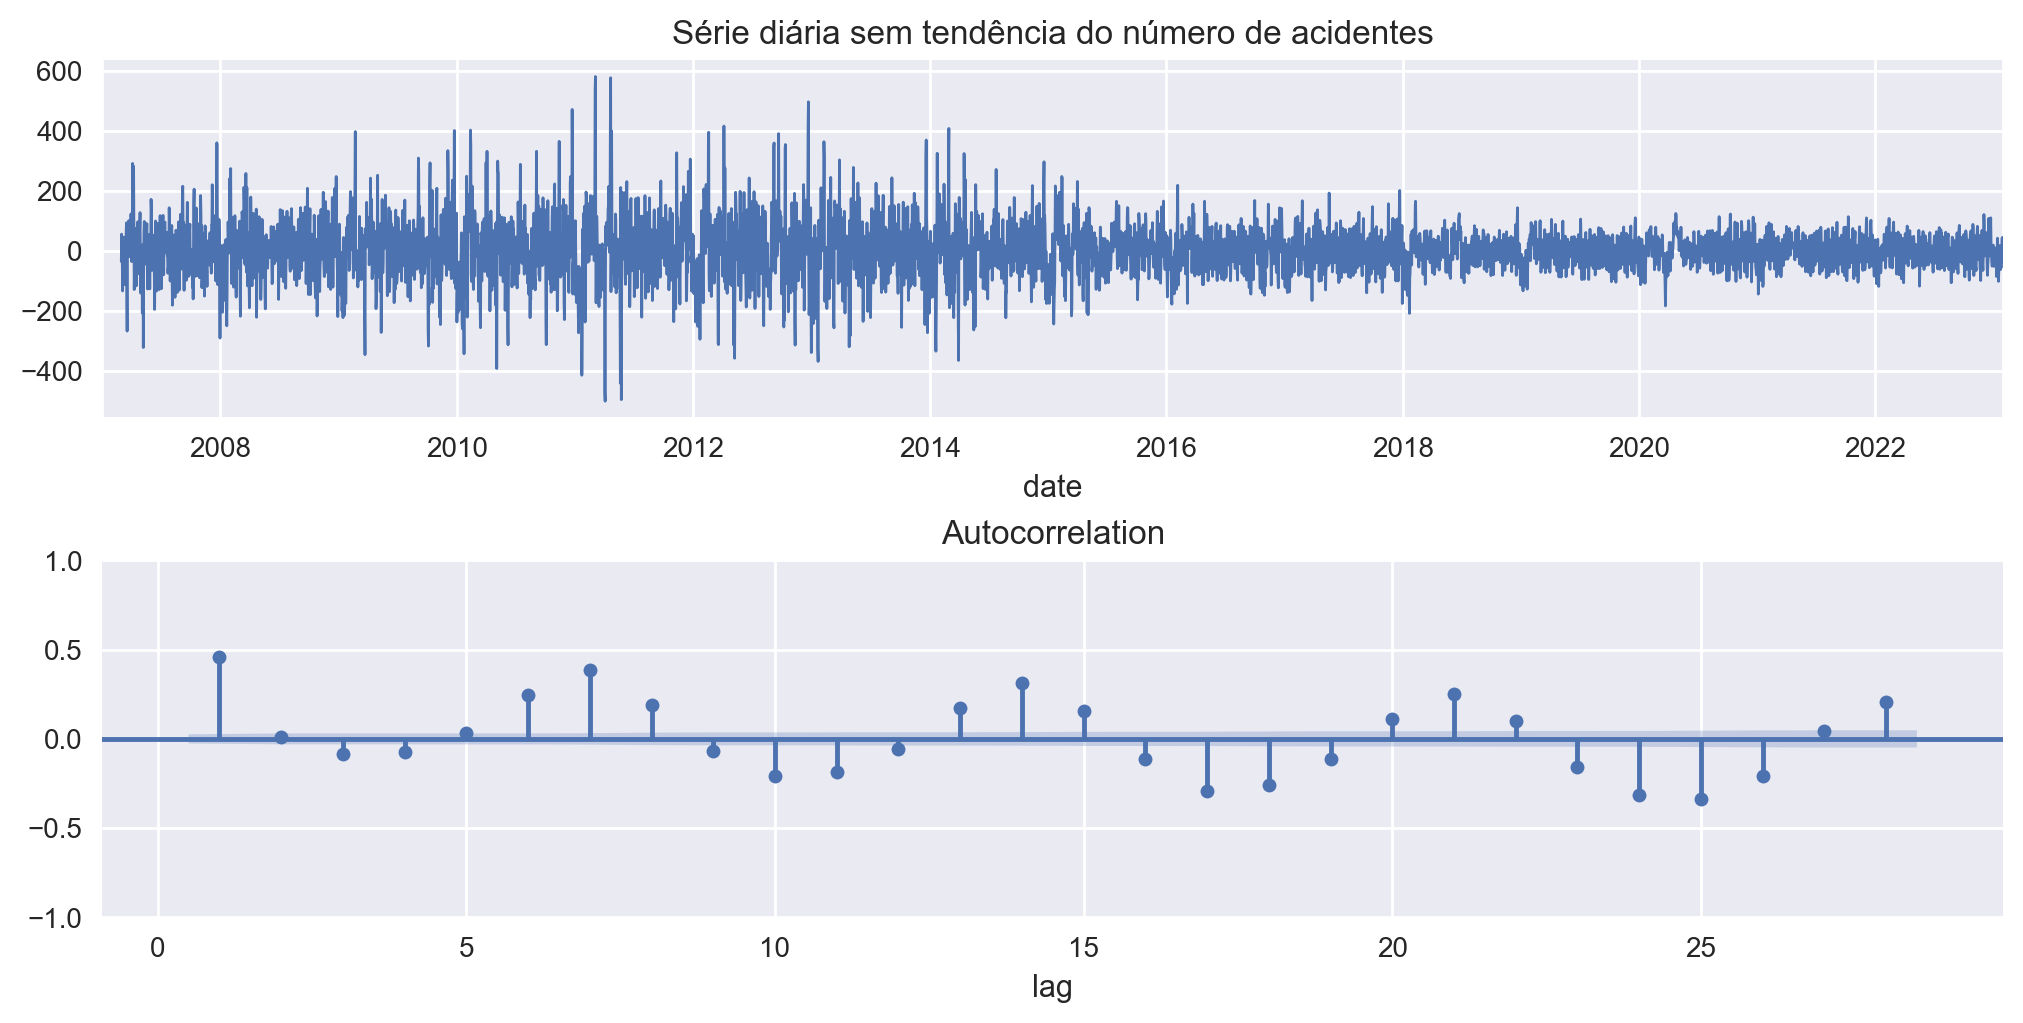

In [232]:
import matplotlib.pyplot as plt
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

plt.style.use('seaborn')

a = train - train.rolling(30).mean() # retirar tendencia

a = a.diff(30) # filtrar sazonalidade

fig, (ax1,ax2) = plt.subplots(2,1, figsize=(10,5), dpi = 200, constrained_layout = True)

a.plot(grid=True, ax = ax1, title = 'Série diária sem tendência do número de acidentes', linewidth = 1, xlabel='date')

plot_acf(a.dropna(), ax=ax2, lags=28, zero=False)
plt.xlabel('lag')
#plt.savefig("C:/Users/Igor/Desktop/PIBIC 2021 e 2022/ciclo_saz_men.pdf", format="pdf", bbox_inches="tight")
plt.show()

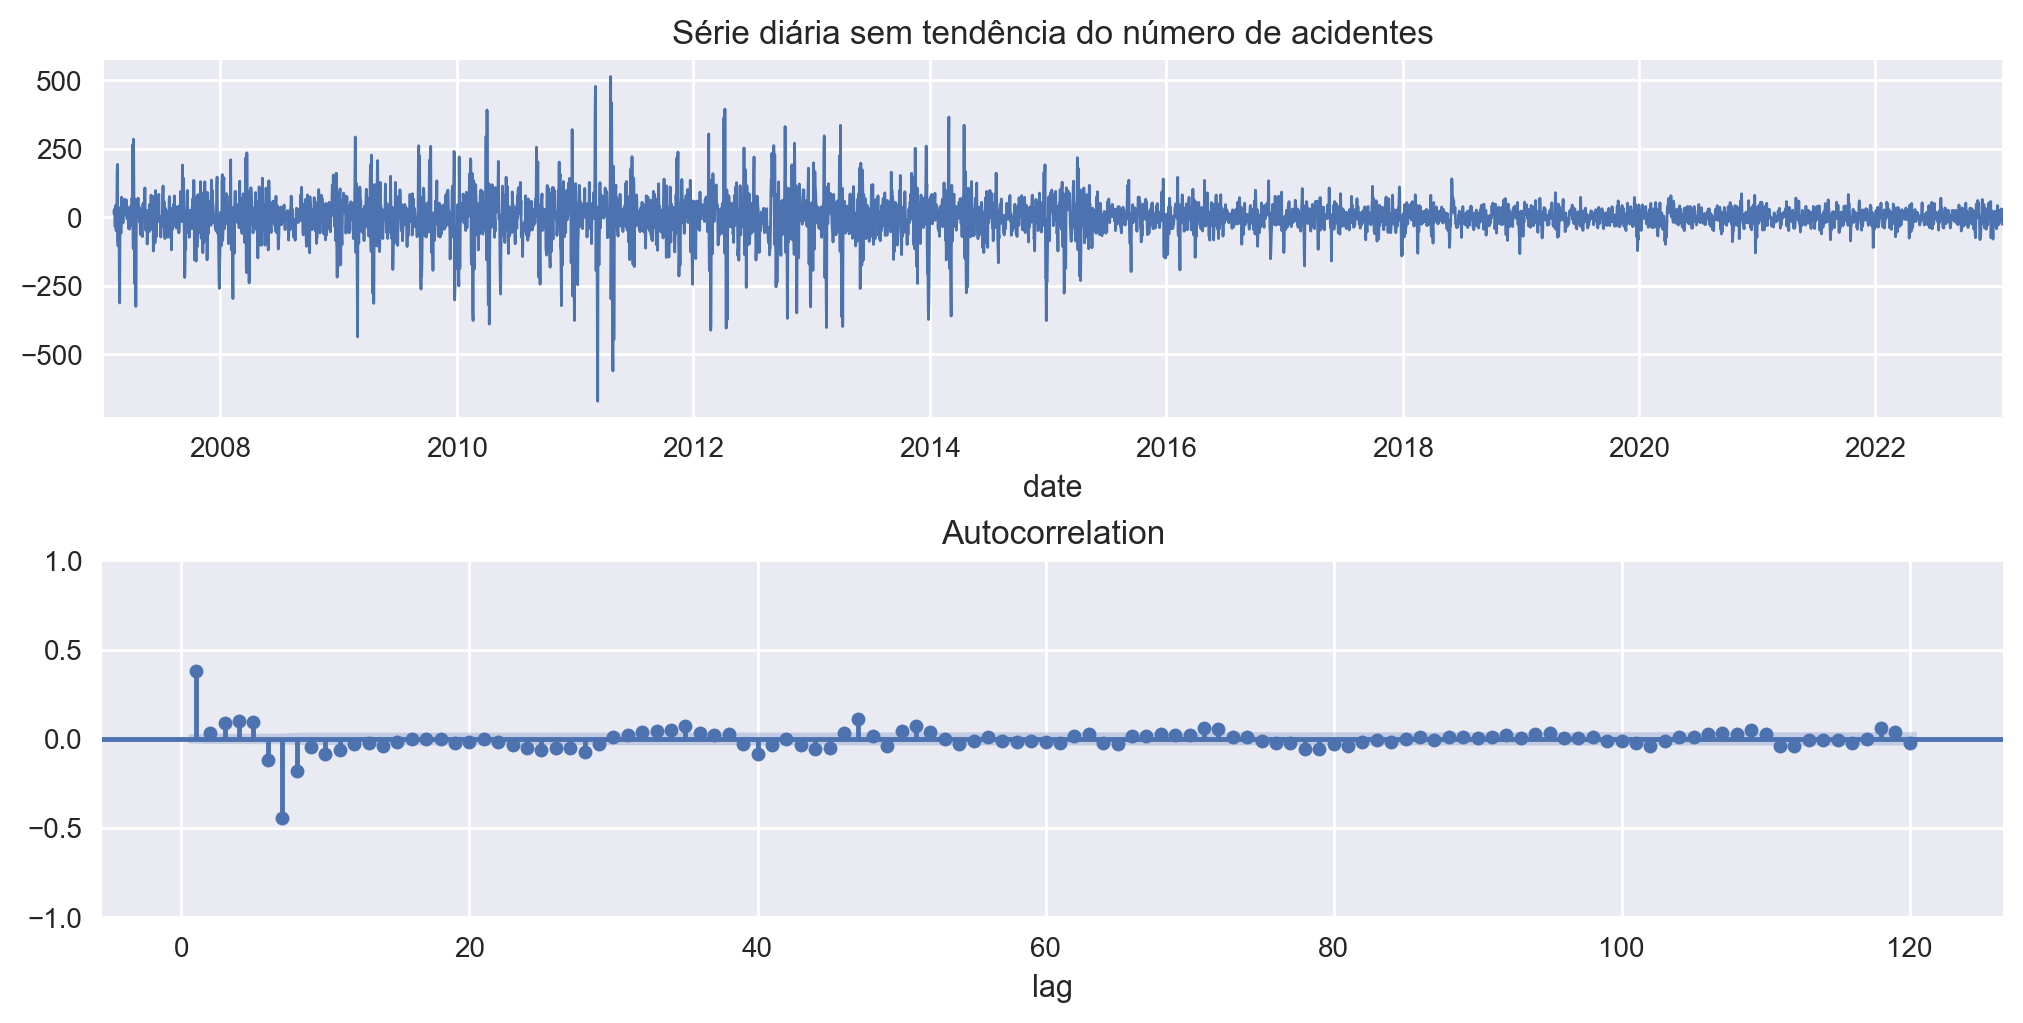

In [231]:
import matplotlib.pyplot as plt
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

plt.style.use('seaborn')

a = train - train.rolling(30).mean() # retirar tendencia

a = a.diff(7) # filtrar sazonalidade

fig, (ax1,ax2) = plt.subplots(2,1, figsize=(10,5), dpi = 200, constrained_layout = True)

a.plot(grid=True, ax = ax1, title = 'Série diária sem tendência do número de acidentes', linewidth = 1, xlabel='date')

plot_acf(a.dropna(), ax=ax2, lags=120, zero=False)
plt.xlabel('lag')
#plt.savefig("C:/Users/Igor/Desktop/PIBIC 2021 e 2022/ciclo_saz_men.pdf", format="pdf", bbox_inches="tight")
plt.show()

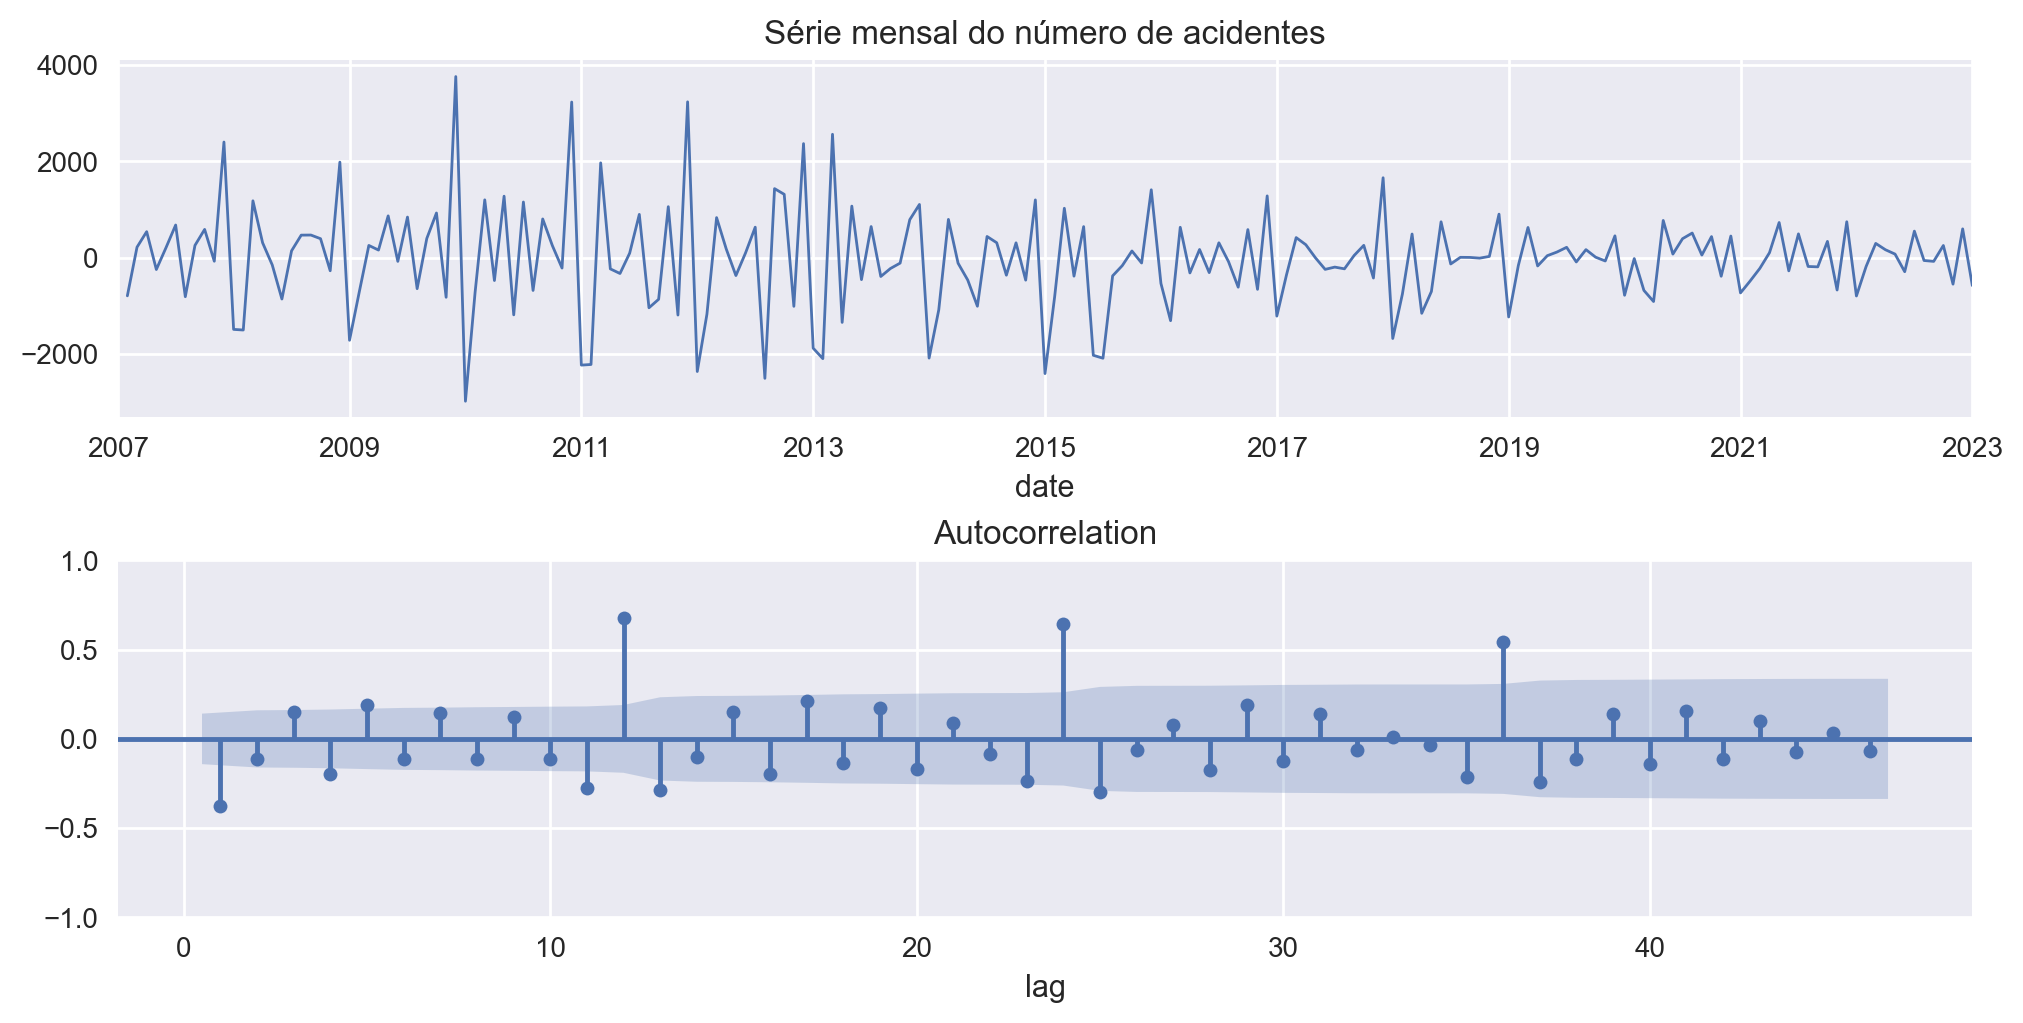

In [230]:
import matplotlib.pyplot as plt
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

plt.style.use('seaborn')

#a = train - train.rolling(30).mean() # retirar tendencia

a = train.resample('M').sum()
a = a.diff()

#a = a.diff(7) # filtrar sazonalidade

fig, (ax1,ax2) = plt.subplots(2,1, figsize=(10,5), dpi = 200, constrained_layout = True)

a.plot(grid=True, ax = ax1, title = 'Série mensal sem tendência do número de acidentes', linewidth = 1, xlabel='date')

plot_acf(a.dropna(), ax=ax2, lags=46, zero=False)
plt.xlabel('lag')
#plt.savefig("C:/Users/Igor/Desktop/PIBIC 2021 e 2022/ciclo_saz_men.pdf", format="pdf", bbox_inches="tight")
plt.show()

In [ ]:
#df['weekday'] = list(map(lambda x: x.weekday(), df['data_inversa']))
#df = pd.get_dummies(df, columns=['weekday'], drop_first=True)

#isnt_na = lambda x: False if bool(__import__('pandas').isna(x)) else True
#filtro1 = np.array(list(map(isnt_na, df['uf'])))
#filtro2 = np.array((list(map(isnt_na, df['br']))))

#df_tcc = df[(filtro1) & (filtro2)]



#import matplotlib.pyplot as plt
#Y_hat_df = Y_hat_df.merge(func.sNAIVE(Y_train_df, 28), how='left', on=['unique_id', 'ds'])
#Y_hat_df = Y_test_df.merge(Y_hat_df, how='left', on=['unique_id', 'ds'])

## FORECAST PLOTS

#fig, ax = plt.subplots(1, 1, figsize = (20, 7))
#plot_df = pd.concat([Y_train_df, Y_hat_df]).set_index('ds')
#plot_df[['y', 'AutoARIMA', 'AutoETS']].plot(ax=ax, linewidth=2)
#ax.set_title('AirPassengers Forecast', fontsize=22)
#ax.set_ylabel('Monthly Passengers', fontsize=20)
#ax.set_xlabel('Timestamp [t]', fontsize=20)
#ax.legend(prop={'size': 15})
#ax.grid()

#plt.show()